In [1]:
#Classes ID and names > for plotting #don't remove

CLASSES_ID = [0, 10, 11, 12, 20, 30, 40, 50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90, 100, 110, 120, 121, 122, 130, 140, 150, 
        151, 152, 153, 160, 170, 180, 190, 200, 201, 202, 210, 220]

CLASSES_NAMES = {
    0: 'No data',
    10: 'Cropland rainfed',
    11: 'Cropland rainfed - Herbaceous cover',
    12: 'Cropland rainfed - Tree or shrub cover',
    20: 'Cropland irrigated or post-flooding',
    30: 'Mosaic cropland (>50%) / natural vegetation (tree/shrub/herbaceous cover) (<50%)',
    40: 'Mosaic natural vegetation (tree/shrub/herbaceous cover) (>50%) / cropland (<50%)',
    50: 'Tree cover broadleaved evergreen closed to open (>15%)',
    60: 'Tree cover  broadleaved  deciduous  closed to open (>15%)',
    61: 'Tree cover  broadleaved  deciduous  closed (>40%)',
    62: 'Tree cover  broadleaved  deciduous  open (15-40%)',
    70: 'Tree cover  needleleaved  evergreen  closed to open (>15%)',
    71: 'Tree cover  needleleaved  evergreen  closed (>40%)',
    72: 'Tree cover  needleleaved  evergreen  open (15-40%)',
    80: 'Tree cover  needleleaved  deciduous  closed to open (>15%)',
    81: 'Tree cover  needleleaved  deciduous  closed (>40%)',
    82: 'Tree cover  needleleaved  deciduous  open (15-40%)',
    90: 'Tree cover  mixed leaf type (broadleaved and needleleaved)',
    100: 'Mosaic tree and shrub (>50%) / herbaceous cover (<50%)',
    110: 'Mosaic herbaceous cover (>50%) / tree and shrub (<50%)',
    120: 'Shrubland',
    121: 'Shrubland evergreen',
    122: 'Shrubland deciduous',
    130: 'Grassland',
    140: 'Lichens and mosses',
    150: 'Sparse vegetation (tree/shrub/herbaceous cover) (<15%)',
    151: 'Sparse tree (<15%)',
    152: 'Sparse shrub (<15%)',
    153: 'Sparse herbaceous cover (<15%)',
    160: 'Tree cover flooded fresh or brakish water',
    170: 'Tree cover flooded saline water',
    180: 'Shrub or herbaceous cover flooded fresh/saline/brakish water',
    190: 'Urban areas',
    200: 'Bare areas',
    201: 'Consolidated bare areas',
    202: 'Unconsolidated bare areas',
    210: 'Water bodies',
    220: 'Permanent snow and ice'
    }

In [2]:
import os
import pandas as pd
import numpy as np

In [3]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support

def gather_accuracy_values_per_class(classes,targets,scores):
    """
    Gather per class a variety of accuracy metrics from targets and scores
    """
    y_pred = np.argmax(scores,axis=1)
    y_true = np.argmax(targets,axis=1)
    
    precision_, recall_, fscore_, support_ = precision_recall_fscore_support(y_true, y_pred, beta=0.5, average=None)

    fscore = pd.Series(index=classes, data=fscore_, name="f-score")
    precision = pd.Series(index=classes, data=precision_, name="precision")
    recall = pd.Series(index=classes, data=recall_, name="recall")
    support = pd.Series(index=classes, data=support_, name="support")
    
    s = [fscore,precision,recall, support]
    names = [el.name for el in s]
    return pd.DataFrame(zip(*s), columns=names, index=recall.index).T

In [4]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, cohen_kappa_score, classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support
 
def gather_mean_accuracies(classes, scores, targets, average='weighted', label="label"):
    """
    calculate a series for mean accuracy values for all, covered (class id < b) and fields (class id > b)
    """
    metrics = []
    
    y_pred = np.argmax(scores,axis=1)
    y_true = np.argmax(targets,axis=1)
        
    # class weighted average accuracy
    w_all = np.ones(y_true.shape[0])
    for idx, i in enumerate(np.bincount(y_true)):
        w_all[y_true == idx] *= (i/float(y_true.shape[0]))
        
    w_acc = accuracy_score(y_true, y_pred, sample_weight=w_all)
    
    metrics.append(pd.Series(data=[w_acc], dtype=float, name="accuracy"))

    # AUC
    try:
        # if AUC not possible skip
        auc = roc_auc_score(targets, scores, average=average)
        metrics.append(pd.Series(data=[auc], dtype=float, name="AUC"))
        
    except:
        print "no AUC calculated"
        pass
    
    # Kappa
    kappa = cohen_kappa_score(y_true, y_pred)
    
    metrics.append(pd.Series(data=[kappa], dtype=float, name="kappa"))

    # Precision, Recall, F1, support
    prec, rec, f1, support = precision_recall_fscore_support(y_true, y_pred, beta=1, average=average)
    
    metrics.append(pd.Series(data=[prec], dtype=float, name="precision"))
    metrics.append(pd.Series(data=[rec], dtype=float, name="recall"))
    metrics.append(pd.Series(data=[f1], dtype=float, name="fscore"))
    
    df_ = pd.DataFrame(metrics).T
    if label is not None:
        df_.index = [[label],["all"]]
    else:
        df_.index = ["all"]
    return df_

In [5]:
savedir = 'acocac'

In [6]:
best_runs = ['1l4r50d2f','1l2r50d2f','1l6r50d1f']
networks = ['lstm','rnn','cnn']

In [25]:
from sklearn.metrics import confusion_matrix

obs_file = "eval_observations.npy"
probs_file = "eval_probabilities.npy"
targets_file = "eval_targets.npy"
conf_mat_file = "eval_confusion_matrix.npy"


networklabels = ["LSTM","RNN","CNN"]

acc=[]
mean = []

cms_targets = []
cms_scores = []
cms_classes = []
for best_run, network, label_ in zip(best_runs,networks,networklabels):
    print network
   
    path = os.path.join(savedir,network,best_run)
    scores = np.load(os.path.join(path,probs_file))
    targets = np.load(os.path.join(path,targets_file))
    y_pred = np.argmax(scores,axis=1)
    y_true = np.argmax(targets,axis=1)
    cm = confusion_matrix(y_true,y_pred)
    labels_idx = list(set(y_pred) | set(y_true))
    mykeys = [CLASSES_ID[i] for i in labels_idx]
    classes = [CLASSES_NAMES[x] for x in mykeys]
    cms_classes.append(classes)
    cms_targets.append(targets)
    cms_scores.append(scores)

    df_ = gather_mean_accuracies(classes, scores, targets, label=label_)
    
    mean.append(df_)
    
mean_df = pd.concat(mean)

lstm
no AUC calculated
rnn
no AUC calculated
cnn
no AUC calculated


In [19]:
mean_df

,,accuracy,kappa,precision,recall,fscore
LSTM,all,0.279363,0.158785,0.206541,0.238661,0.193958
RNN,all,0.271999,0.158263,0.193011,0.234649,0.194218
CNN,all,0.224980,0.105055,0.138745,0.187101,0.134415


In [32]:
# performance by model by class
models = {'lstm': 0,'rnn':1, 'cnn':2}
model = 'lstm'
gather_accuracy_values_per_class(cms_classes[models[model]],cms_targets[models[model]],cms_scores[models[model]])

,Cropland rainfed,Cropland rainfed - Herbaceous cover,Cropland rainfed - Tree or shrub cover,Mosaic cropland (>50%) / natural vegetation (tree/shrub/herbaceous cover) (<50%),Mosaic natural vegetation (tree/shrub/herbaceous cover) (>50%) / cropland (<50%),Tree cover broadleaved evergreen closed to open (>15%),Tree cover broadleaved deciduous closed to open (>15%),Tree cover broadleaved deciduous closed (>40%),Tree cover broadleaved deciduous open (15-40%),Mosaic tree and shrub (>50%) / herbaceous cover (<50%),Shrubland,Grassland,Sparse vegetation (tree/shrub/herbaceous cover) (<15%),Shrub or herbaceous cover flooded fresh/saline/brakish water,Urban areas,Water bodies
f-score,0.0,0.389761,0.0,0.170182,0.0,0.532031,0.000810,0.243980,0.0,0.0,0.068936,0.0,0.0,0.143456,0.0,0.560847
precision,0.0,0.351199,0.0,0.174886,0.0,0.573495,0.120000,0.251543,0.0,0.0,0.056407,0.0,0.0,0.252729,0.0,0.531240
recall,0.0,0.695013,0.0,0.153654,0.0,0.412683,0.000163,0.217787,0.0,0.0,0.617832,0.0,0.0,0.052558,0.0,0.721739
support,24081.0,28152.000000,0.0,13179.000000,18354.0,24978.000000,18423.000000,15157.000000,0.0,8372.0,6348.000000,7314.0,0.0,5727.000000,0.0,2415.000000


In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_confusion_matrix(confusion_matrix, classes, normalize_axis=None, figsize=(7, 7), colormap=None):
    """
    Plots a confusion matrix using seaborn heatmap functionality

    @param confusion_matrix: np array [n_classes, n_classes] with rows reference and cols predicted
    @param classes: list of class labels
    @param normalize_axis: 0 sum of rows, 1: sum of cols, None no normalization

    @return matplotlib figure
    """
    # Set up the matplotlib figure
    plt.figure()
    f, ax = plt.subplots(figsize=figsize)

    # normalize
    normalized_str = ""  # add on at the title
    if normalize_axis is not None:

        with np.errstate(divide='ignore'):  # ignore divide by zero and replace with 0
            confusion_matrix = np.nan_to_num(
                confusion_matrix.astype(float) / np.sum(confusion_matrix, axis=normalize_axis))

        
    # Draw the heatmap with the mask and correct aspect ratio
    g = sns.heatmap(confusion_matrix,
                    square=True,
                    linewidths=1, 
                    cbar=False,
                    ax=ax, 
                    cmap=colormap, vmin=0, vmax=1)
    
    divider = make_axes_locatable(g)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    cbar = g.figure.colorbar(ax.collections[0],cax=cax)
    if normalize_axis == 0:
        cbar.set_label("precision")
    if normalize_axis == 1:
        cbar.set_label("recall")

    n_classes = len(classes)
    # if n_classes < threshold plot values in plot

    cols = np.arange(0, n_classes)
    rows = np.arange(n_classes - 1, -1, -1)

    #g.set_title("Confusion Matrix")
    g.set_xticklabels([])
    g.set_yticklabels(classes[::-1], rotation=0)
    g.set_xlabel("predicted")
    g.set_ylabel("reference")

    return f, g

/home/acocac/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in divide
/home/acocac/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in divide
/home/acocac/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in divide


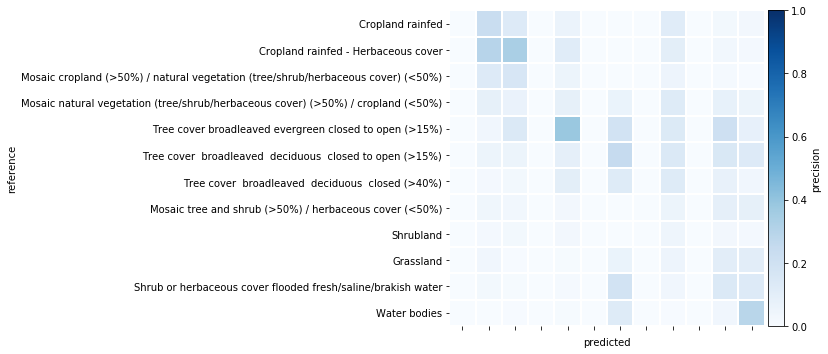

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline

networks = ["lstm","rnn","cnn"]

def calc_confusion_matrix(path):
    probs_file = "eval_probabilities.npy"
    targets_file = "eval_targets.npy"

    scores = np.load(os.path.join(path,probs_file))
    targets = np.load(os.path.join(path,targets_file))

    y_pred = np.argmax(scores,axis=1)
    y_true = np.argmax(targets,axis=1)
    labels = list(set(y_pred) | set(y_true))
    cm = confusion_matrix(y_true,y_pred)

    return cm, labels

cms_prec = []
cms_rec = []
cms_labels = []
for best_run, network in zip(best_runs, networks):
    path = os.path.join(savedir, network, best_run)
    cm, labels = calc_confusion_matrix(path)
    cms_labels.append(labels)
    cms_prec.append(cm.astype(float)/np.sum(cm,axis=0))
    cms_rec.append(cm.astype(float)/np.sum(cm,axis=1))
    
models = {'lstm': 0,'rnn':1, 'cnn':2}
model = 'cnn'
cm = cms_prec[models[model]] #0: lstm, 1:rnn, 2:cnn
labels_idx = cms_labels[models[model]]
mykeys = [CLASSES_ID[i] for i in labels_idx]
labels = [CLASSES_NAMES[x] for x in mykeys]

# Generate a custom diverging colormap
cmap = sns.color_palette("Blues")
figsize=(6,6)
f,ax = plot_confusion_matrix(cm, labels[::-1], figsize=figsize, normalize_axis=0, colormap = "Blues")

# double checked at http://stackoverflow.com/questions/20927368/python-how-to-normalize-a-confusion-matrix
precision = cm/np.sum(cm,axis=0)
recall = cm/np.sum(cm,axis=1)

## Influence of element in sequence

In [117]:
networks = ['lstm','rnn','cnn']

lstm_network, _, _ = networks
lstm_best, _, _ = best_runs
path = os.path.join(savedir, lstm_network, lstm_best)

obs = np.load(os.path.join(path,obs_file))
scores = np.load(os.path.join(path,probs_file))
targets = np.load(os.path.join(path,targets_file))

In [118]:
def get_obs_subset(targets,scores,obs,obs_idx, classes):
    """
    This function calls the gather_mean_accuracies, which is used for the calculation of accuracy tables
    on a subset of targets and scores filtered by obs_idx
    """
    # select by observation
    sc = scores[obs==obs_idx]
    ta = targets[obs==obs_idx]
    
    return gather_mean_accuracies(classes, sc, ta, average='weighted', label="label")

In [119]:
#a = get_obs_subset(targets,scores,3, b, classes)
sc = scores[obs==0]
ta = targets[obs==0]
gather_mean_accuracies(classes, sc, ta, average='weighted', label="label")

no AUC calculated


,,accuracy,kappa,precision,recall,fscore
label,all,0.243959,0.097076,0.109023,0.197333,0.131157


In [120]:
# gather accuracy values for fields
#from util.db import conn
import sklearn

#t = pd.read_sql("select distinct doa, doy from products order by doa",conn)["doy"]
#t.to_pickle(os.path.join("loc","t.pkl"))

#t = pd.read_pickle(os.path.join("loc","t.pkl"))

def collect_data_per_obs(targets, scores, obs, classes, metric="accuracy", classcategory="all"):
    """
    this function calculates `metric` based on scores and targets for each available observations `t` 0..25
    
    This function takes a 
    - target matrix resembling ground thruth, 
    - scores as calculated probablities for each observation
    - obs as indices of observation
    """
    
    #oa = []
    outlist=[]
    for i in range(len(t)):
        try:
            per_class_ = get_obs_subset(targets,scores,obs,i, classes)
        #per_class.append(per_class_.mean(axis=0))
        # append the average <classcategory> <metric> at each time i
            outlist.append(per_class_.loc["label"].loc[classcategory][metric])
        except:
            print "t{} could not calculate accuracy metrics".format(i)
            outlist.append(None)
            pass
        #oa.append(oa_)
        
        print "Collecting doy {} ({}/{})".format(t[i],i+1,len(t))

    #oa_s = pd.Series(data=oa, name=over_accuracy_label, index=t)
    return pd.DataFrame(outlist, index=t)


def collect_data_for_each_network(networks, best_runs, metric="kappa", classcategory="all"):
    """
    This function calls collect_data_per_obs for each network.
    First targets, scores and obs are loaded from file at the respective network's best run model
    Then collect_data_per_obs is called.
    """
    
    acc_dfs = []
    for network, best in zip(networks, best_runs):
        path = os.path.join(savedir, network, best)

        obs = np.load(os.path.join(path,obs_file))
        scores = np.load(os.path.join(path,probs_file))
        targets = np.load(os.path.join(path,targets_file))
        print 
        print network
        # for every network append a dataframe of observations
        observations_df_ = collect_data_per_obs(targets, scores, obs, classes, metric=metric, classcategory=classcategory)
        acc_dfs.append(observations_df_.values.reshape(-1))

    # create final DataFrame with proper column and indexes of all three networks
    return pd.DataFrame(acc_dfs, index=networks,columns=t).T

In [121]:
acc_df = collect_data_for_each_network(networks, best_runs, metric="accuracy", classcategory="all")
rec_df = collect_data_for_each_network(networks, best_runs, metric="recall", classcategory="all")
kappa_df = collect_data_for_each_network(networks, best_runs, metric="kappa", classcategory="all")
prec_df = collect_data_for_each_network(networks, best_runs, metric="precision", classcategory="all")


lstm
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated

rnn
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated

cnn
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calculated
no AUC calcu

In [122]:
acc_df.T

,1,17,33,49,65,81,97,113,129,145,...,209,225,241,257,273,289,305,321,337,353
lstm,0.243959,0.280707,0.271837,0.278332,0.288111,0.29449,0.306464,0.304739,0.303024,0.293548,...,0.265525,0.255994,0.255867,0.259112,0.267266,0.277794,0.280721,0.283139,0.289917,0.289422
rnn,0.232646,0.254212,0.246670,0.240512,0.256309,0.27960,0.292688,0.301663,0.304844,0.308188,...,0.292861,0.277925,0.259859,0.250409,0.242851,0.241947,0.251729,0.257687,0.258284,0.271686
cnn,0.236230,0.250015,0.212995,0.221741,0.232251,0.23821,0.214148,0.228489,0.216715,0.205585,...,0.204786,0.203093,0.216579,0.220864,0.242486,0.261175,0.256758,0.247613,0.250048,0.240585


In [123]:
x = range(len(t))

def plot_acctime(x,acc_df,metric="measure"):
    f,ax = plt.subplots()
    #ax.plot(x,oa_s.values, label="overall accuracy")
    for col in acc_df.columns:
        ax.plot(x,acc_df[col].values, label=col)
    plt.xticks(x,t, rotation='vertical')
    ax.set_xlabel("day of year")
    ax.set_ylabel(metric)
    plt.legend()
    
# 0 lstm, 1 rnn, 2 cnn
#plot_acctime(x,prec_df)

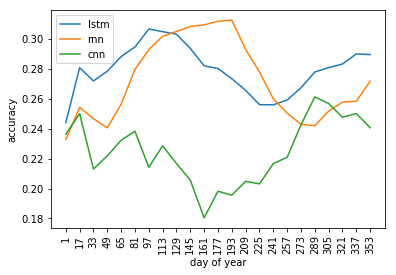

In [124]:
plot_acctime(x,acc_df,metric="accuracy")

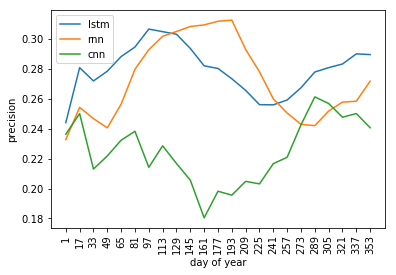

In [125]:
plot_acctime(x,acc_df,metric="precision")